In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analyzing-credit-card-spending-habits-in-india/Credit card transactions - India - Simple.csv
/kaggle/input/newdata/Credit card transactions.csv


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# Importing the dataset
data=pd.read_csv("/kaggle/input/newdata/Credit card transactions.csv")

# **Checking the dataset**

In [90]:
# Check the size of the dataset
data.shape


(26052, 7)

This dataset has 26052 Rows and 7 Columns

In [91]:
# Get top 5 rows
data.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574


Column Names are:
* index - index
* City - The city in which the transaction took place
* Date - The date of the transaction
* Card Type - The type of credit card used for the transaction (Gold, Platinum, Silver, Signature)
* Exp Type - The type of expense associated with the transaction (Bills, Food, Entertainment, Grocery, Fuel, Travel)
* Gender - The gender of the cardholder (Male, Female)
* Amount - The amount of the transaction

In [92]:
# Check for null values
data.isnull().sum()

index        0
City         0
Date         0
Card Type    0
Exp Type     0
Gender       0
Amount       0
dtype: int64

There is no null values


In [93]:
# Checking for duplicate
data.duplicated().sum()

0

There is no duplicates


## **Date Feature Engineering**

In [94]:
# Spliting City into City and Country and taking only City
data["City"]=data["City"].str.split(",",expand=True)[0]

----

In [95]:
# Extract Month and Day from the datetime object
data["Date"] = pd.to_datetime(data["Date"], format='%d-%b-%y')
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.dayofweek
data["MonthName"] = data["Date"].dt.month_name()
data["DayName"] = data["Date"].dt.day_name()
data["Year"] = data["Date"].dt.year
data.head()


,index,City,Date,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year
0,0,Delhi,2014-10-29,Gold,Bills,F,82475,10,2,October,Wednesday,2014
1,1,Greater Mumbai,2014-08-22,Platinum,Bills,F,32555,8,4,August,Friday,2014
2,2,Bengaluru,2014-08-27,Silver,Bills,F,101738,8,2,August,Wednesday,2014
3,3,Greater Mumbai,2014-04-12,Signature,Bills,F,123424,4,5,April,Saturday,2014
4,4,Bengaluru,2015-05-05,Gold,Bills,F,171574,5,1,May,Tuesday,2015


In [96]:
print(f"Number of unique values in Day column: {data['Day'].unique().size}")
print(f"Number of unique values in Month column: {data['Month'].unique().size}")

Number of unique values in Day column: 7
Number of unique values in Month column: 12


Since this will also contribute to the complexity of the model, We will reduce the model complexity using cyclic encoding

### Cyclic encoding

Why Cyclic Encoding? <br>
* Unlike one-hot encoding, cyclical encoding ensures that adjacent cyclical values retain their relationships (e.g., December is adjacent to January). <br>
* Cyclical encoding requires fewer dimensions than one-hot encoding, leading to more efficient data representation

In [97]:
def encodeCyclic(value, maxValue):
    radians = 2 * np.pi * value / maxValue
    return np.sin(radians), np.cos(radians)

data['MonthSin'], data['MonthCos'] = zip(*data['Month'].apply(lambda x: encodeCyclic(x-1, 12)))

data['DaySin'], data['DayCos'] = zip(*data['Day'].apply(lambda x: encodeCyclic(x, 7)))

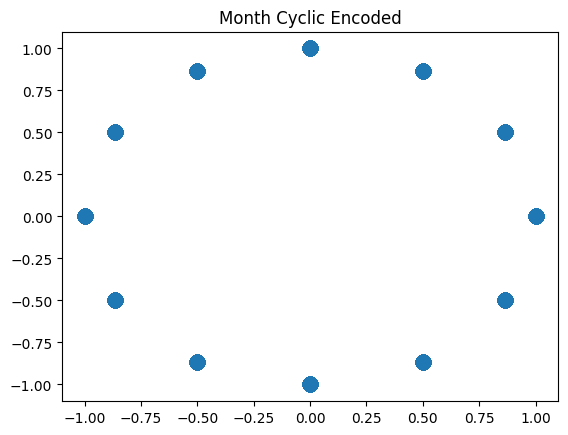

In [98]:
plt.plot(data['MonthSin'],data['MonthCos'],marker = 'o',markersize = 10, linewidth = 0)
plt.title('Month Cyclic Encoded')
plt.show()

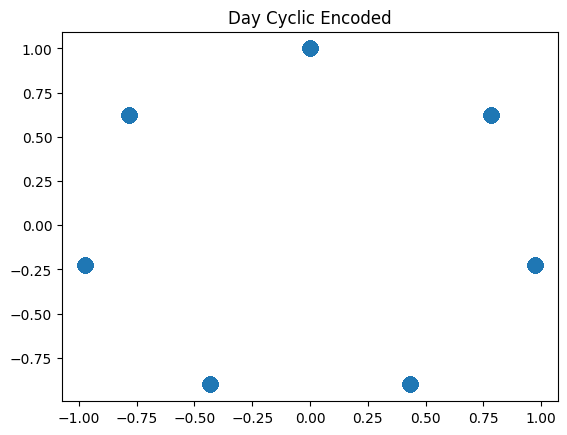

In [99]:
plt.plot(data['DaySin'],data['DayCos'],marker = 'o',markersize = 10, linewidth = 0)
plt.title('Day Cyclic Encoded')
plt.show()

----

In [100]:
print(f"Number of unique values in City column: {data['City'].unique().size}")

Number of unique values in City column: 986


Since there are 986 values in the city column it will increase the complexity of the model even more leading to overfitting. To avoid that we are going to use city encoding into tiers.

### Encoding Cities into Tiers

The spending paterns are affected by the city/town in which the customer lives. For example a person from highly developed city with high gross income per person will use thier credit card more, meanwhile a person from under developed city may not even know what a credit card is.

The classification of Indian cities is a ranking system used by the Government of India to allocate House Rent Allowance (HRA) to public servants employed in cities in India. India has been divided into various categories by the **Pay Commission**. There has been multiple types of classifications.

**Tier Classification:** RBI classifies the cities under Tier 1-6 categories based on their population.
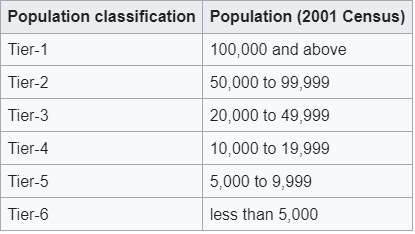

**Rural, Urban classifications:** <br>
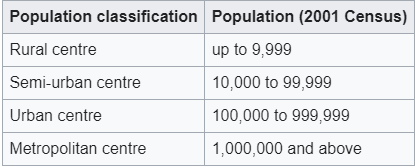

Before 2008, there were two categories in which the cities were classified in India. This was called the Historical classification and the cities were classified before the Sixth Pay Commission's recommendations. 

**HRA classification:**

Under the recommendation of the Seventh Central Pay Commission, the CCA classification was abolished in 2008. The earlier HRA classification of cities was changed from 
*     A-1 to X 
*     A, B-1, and B-2 to Y 
*     C and unclassified cities to Z

X, Y, and Z are more commonly known as Tier-1, Tier-2, and Tier-3 cities,

There are eight X cities and 97 Y cities in India. 
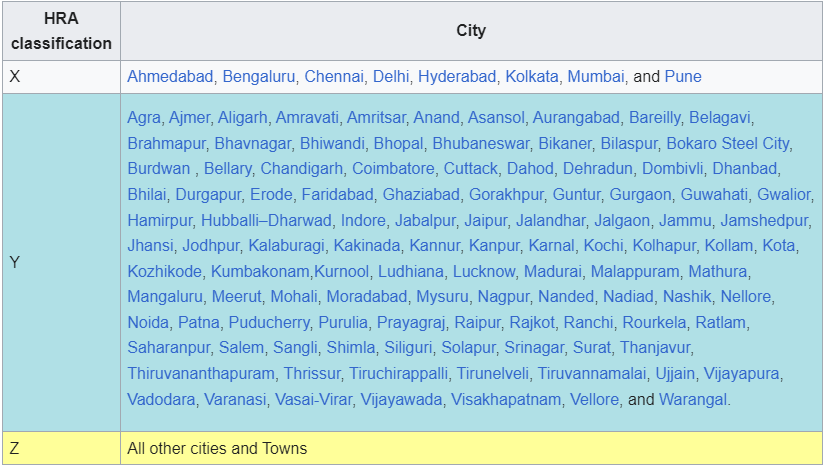

References -
* https://en.wikipedia.org/wiki/Classification_of_Indian_cities
* https://www.jagranjosh.com/general-knowledge/explained-classification-of-indian-cities-into-tiers-reason-categorization-and-other-details-1629375309-1

Suggestion - Dr. Damayanthi

In [101]:
t1=['Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune']
t2=['Ajmer','Aligarh','Amravati','Amritsar','Anand','Asansol','Aurangabad','Bareilly','Belagavi','Bhavnagar','Bhiwandi','Bhopal','Bhubaneswar','Bikaner','Bilaspur','Bokaro Steel City','Burdwan','Chandigarh','Coimbatore','Cuttack','Dahod','Dehradun','Dombivli','Dhanbad','Bhilai','Durgapur','Erode','Faridabad','Ghaziabad','Gorakhpur','Guntur','Gurugram','Guwahati','Gwalior','Hamirpur','Hubli-Dharwad','Indore','Jabalpur','Jaipur','Jalandhar','Jalgaon','Jammu','Jamnagar','Jamshedpur','Jhansi','Jodhpur','Kalaburagi','Kakinada','Kannur','Kanpur','Karnal','Kochi','Kolhapur','Kollam','Kozhikode','Kurnool','Ludhiana','Lucknow','Madurai','Malappuram','Mathura','Mangaluru','Meerut','Moradabad','Mysore','Nagpur','Nanded-Waghala','Nashik','Nellore','Noida','Patna','Puducherry','Purulia','Prayagraj','Raipur','Rajkot','Rajahmundry','Ranchi','Rourkela','Ratlam','Salem','Sangli','Shimla','Siliguri','Solapur','Srinagar','Surat','Thanjavur','Thiruvananthapuram','Thrissur','Tiruchirappalli','Tirunelveli','Tiruvannamalai','Ujjain','Vijayapura','Vadodara','Varanasi','Vasai-Virar','Vijayawada','Visakhapatnam','Vellore','Warangal']

def city_tier(city):
  if city in t1:
    return 'Tier-1'
  elif city in t2:
    return 'Tier-2'
  else :
    return 'Tier-3'

data['City'] = data['City'].apply(lambda x: x.split(',')[0])
data['City Tier'] = data['City'].apply(lambda x: city_tier(x))

In [102]:
print(f"Number of unique values in City column: {data['City Tier'].unique().size}")

Number of unique values in City column: 3


Now, 986 values are reduced to 3 values and this will improve the model performance.

In [103]:
data.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,0,Delhi,2014-10-29,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,1,Greater Mumbai,2014-08-22,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,2,Bengaluru,2014-08-27,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,3,Greater Mumbai,2014-04-12,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,4,Bengaluru,2015-05-05,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1


In [104]:
data.drop(columns=["Date","index"], inplace=True)

In [105]:
data

,City,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,Delhi,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,Greater Mumbai,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,Bengaluru,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,Greater Mumbai,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,Bengaluru,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26047,Kolkata,Silver,Travel,F,128191,6,6,June,Sunday,2014,0.500000,-8.660254e-01,-0.781831,0.623490,Tier-1
26048,Pune,Signature,Travel,M,246316,8,6,August,Sunday,2014,-0.500000,-8.660254e-01,-0.781831,0.623490,Tier-1
26049,Hyderabad,Silver,Travel,M,265019,1,4,January,Friday,2015,0.000000,1.000000e+00,-0.433884,-0.900969,Tier-1
26050,Kanpur,Silver,Travel,M,88174,9,6,September,Sunday,2014,-0.866025,-5.000000e-01,-0.781831,0.623490,Tier-2


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       26052 non-null  object 
 1   Card Type  26052 non-null  object 
 2   Exp Type   26052 non-null  object 
 3   Gender     26052 non-null  object 
 4   Amount     26052 non-null  int64  
 5   Month      26052 non-null  int32  
 6   Day        26052 non-null  int32  
 7   MonthName  26052 non-null  object 
 8   DayName    26052 non-null  object 
 9   Year       26052 non-null  int32  
 10  MonthSin   26052 non-null  float64
 11  MonthCos   26052 non-null  float64
 12  DaySin     26052 non-null  float64
 13  DayCos     26052 non-null  float64
 14  City Tier  26052 non-null  object 
dtypes: float64(4), int32(3), int64(1), object(7)
memory usage: 2.7+ MB


In [107]:
data.head()

,City,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,Delhi,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,Greater Mumbai,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,Bengaluru,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,Greater Mumbai,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,Bengaluru,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1


## **EDA**

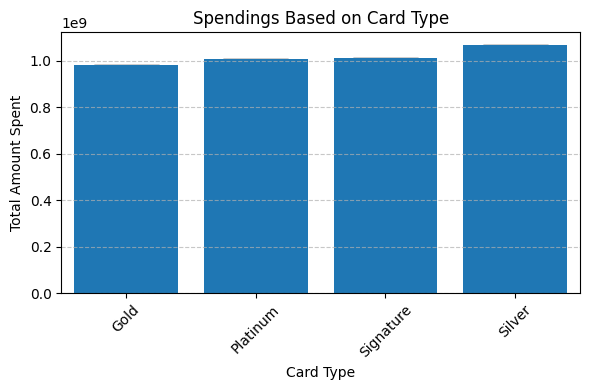

In [108]:
# Checking the usage based on card type 
groupedByCardType = data.groupby('Card Type')['Amount'].sum()
plt.figure(figsize=(6, 4))
groupedByCardType.plot(kind='bar', edgecolor='k')
plt.bar(groupedByCardType.index, groupedByCardType)
plt.xlabel('Card Type')
plt.ylabel('Total Amount Spent')
plt.title('Spendings Based on Card Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

It can be seen that the silver card has the most usage


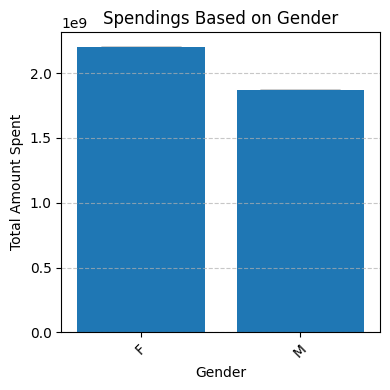

In [109]:
# Checking the usage based on gender
groupedByGender = data.groupby('Gender')['Amount'].sum()
plt.figure(figsize=(4, 4))
groupedByGender.plot(kind='bar', edgecolor='k')
plt.bar(groupedByGender.index, groupedByGender)
plt.xlabel('Gender')
plt.ylabel('Total Amount Spent')
plt.title('Spendings Based on Gender')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can see females spending more amount than males.


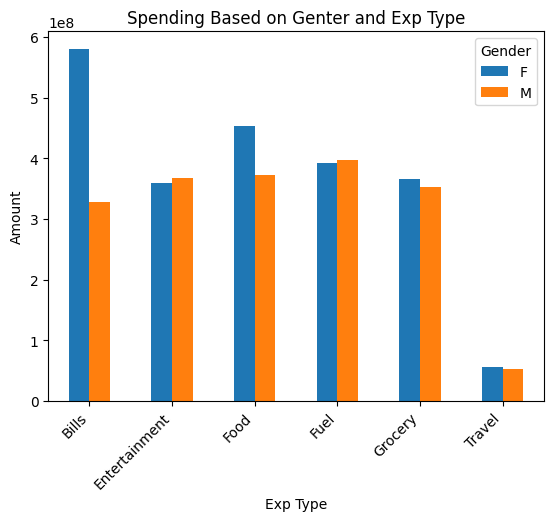

<Figure size 640x480 with 0 Axes>

In [110]:
# Checking the spending based on gender and Exp Type
groupedData = data.groupby(['Exp Type', 'Gender'])['Amount'].sum().unstack()
groupedData.plot(kind='bar', stacked=False)
plt.xlabel('Exp Type')
plt.ylabel('Amount')
plt.title('Spending Based on Genter and Exp Type')
plt.legend(title='Gender', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()
plt.savefig('Spending_by_gender_exp_type.png')


We can see more number of transactons in bills are the highst followed by food made by female customers.
Expences for fuel is high in male customers.


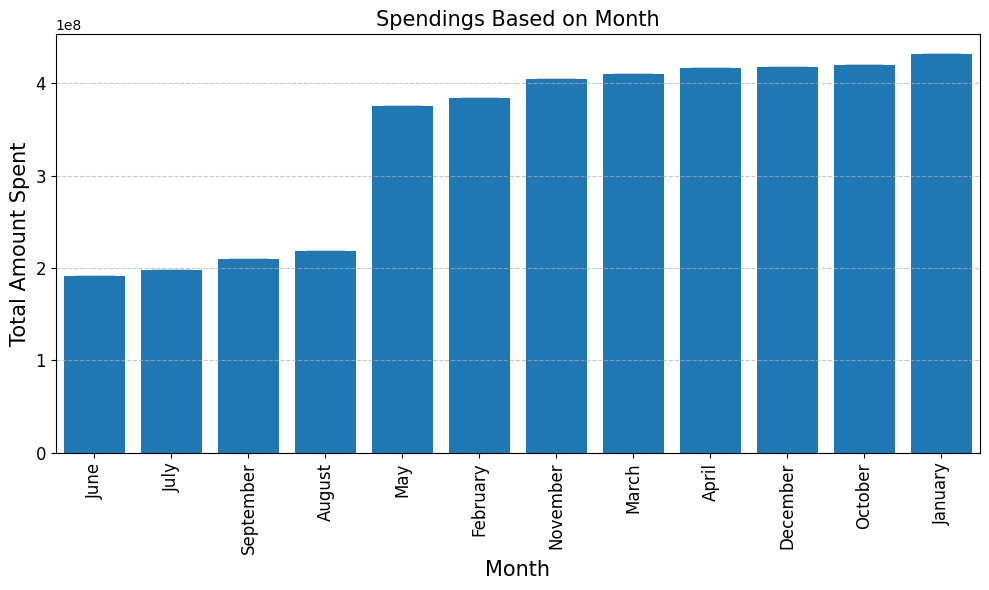

In [111]:
# Chekcking the spending based on months
groupedByMonth = data.groupby('MonthName')['Amount'].sum()
groupedByMonth = groupedByMonth.sort_values()
plt.figure(figsize=(10, 6))
groupedByMonth.plot(kind='bar', edgecolor='k')
plt.bar(groupedByMonth.index, groupedByMonth)
plt.xlabel('Month', fontsize = '15')
plt.ylabel('Total Amount Spent', fontsize = '15')
plt.title('Spendings Based on Month', fontsize = '15')
plt.xticks(rotation=90,fontsize='12')
plt.yticks(fontsize='12')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

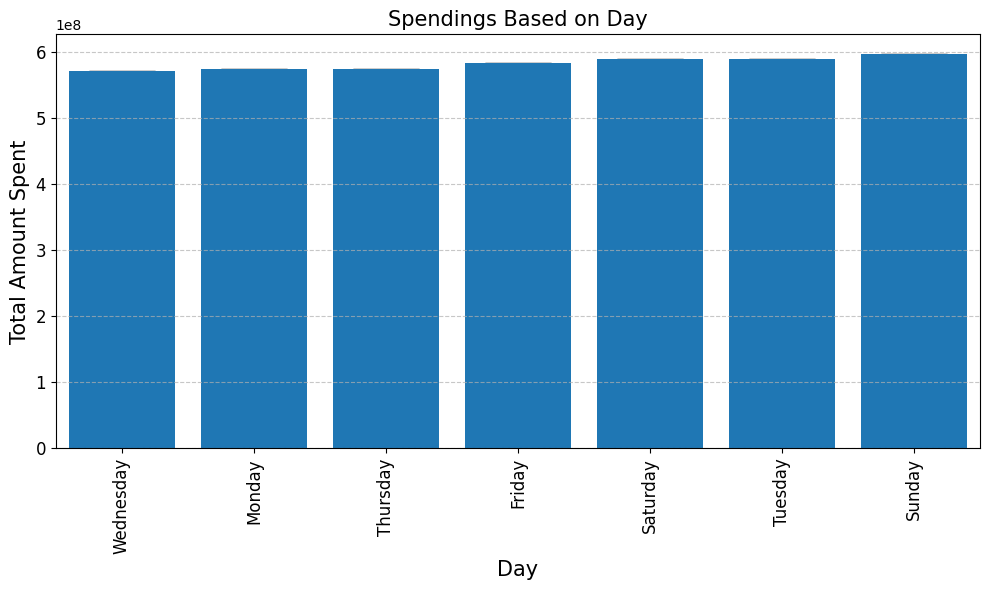

In [112]:
# Chekcking the spending based on days of the week
groupedByDay = data.groupby('DayName')['Amount'].sum()
groupedByDay = groupedByDay.sort_values()
plt.figure(figsize=(10, 6))
groupedByDay.plot(kind='bar', edgecolor='k')
plt.bar(groupedByDay.index, groupedByDay)
plt.xlabel('Day', fontsize = '15')
plt.ylabel('Total Amount Spent', fontsize = '15')
plt.title('Spendings Based on Day', fontsize = '15')
plt.xticks(rotation=90,fontsize='12')
plt.yticks(fontsize='12')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Total Cities 986


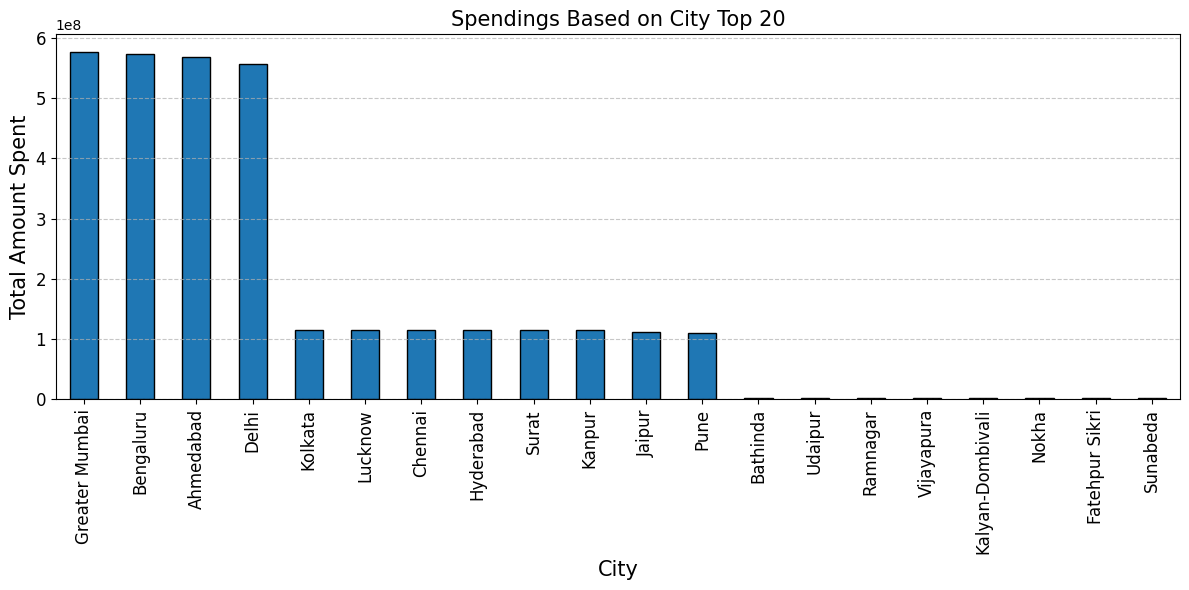

In [113]:
# Get the top 10 spending cities
topCities = data.groupby('City')['Amount'].sum().nlargest(20).index
# print(topCities)
uniqueCities = data['City'].unique()
print("Total Cities", len(uniqueCities))
# Select only the top 10 cities
dataTopCities = data[data['City'].isin(topCities)]
groupedByCity = dataTopCities.groupby('City')['Amount'].sum()
groupedByCity = groupedByCity.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
groupedByCity.plot(kind='bar', edgecolor='k')
plt.xlabel('City', fontsize=15)
plt.ylabel('Total Amount Spent', fontsize=15)
plt.title('Spendings Based on City Top 20', fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

It can be seen that 4 cities are spending much more than other 982 cities in the data set

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


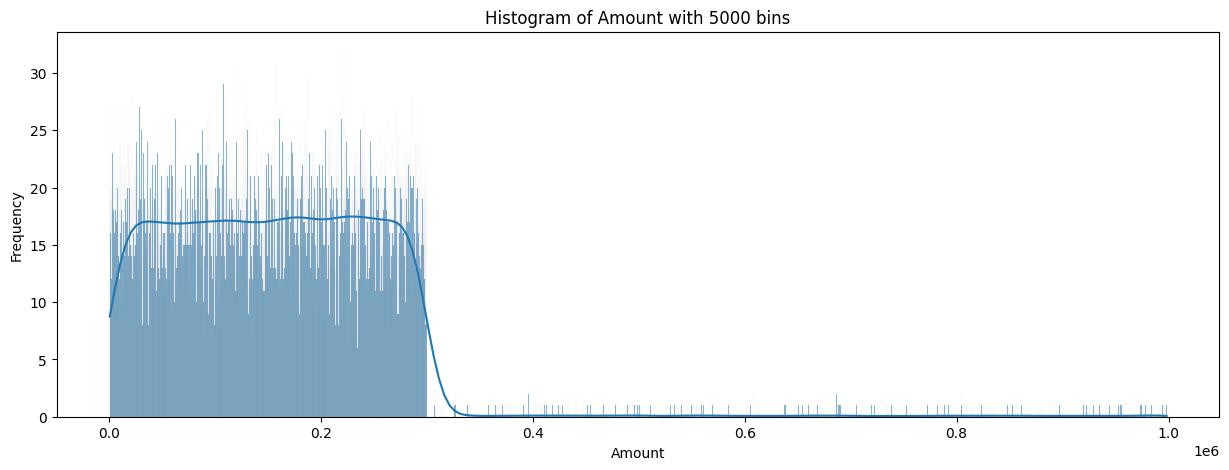

In [114]:
plt.figure(figsize=(15, 5))
sns.histplot(data['Amount'], bins=5000, kde=True)
plt.title('Histogram of Amount with 5000 bins')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [115]:
# Removing outliars
data = data[data['Amount'] <= 300000]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


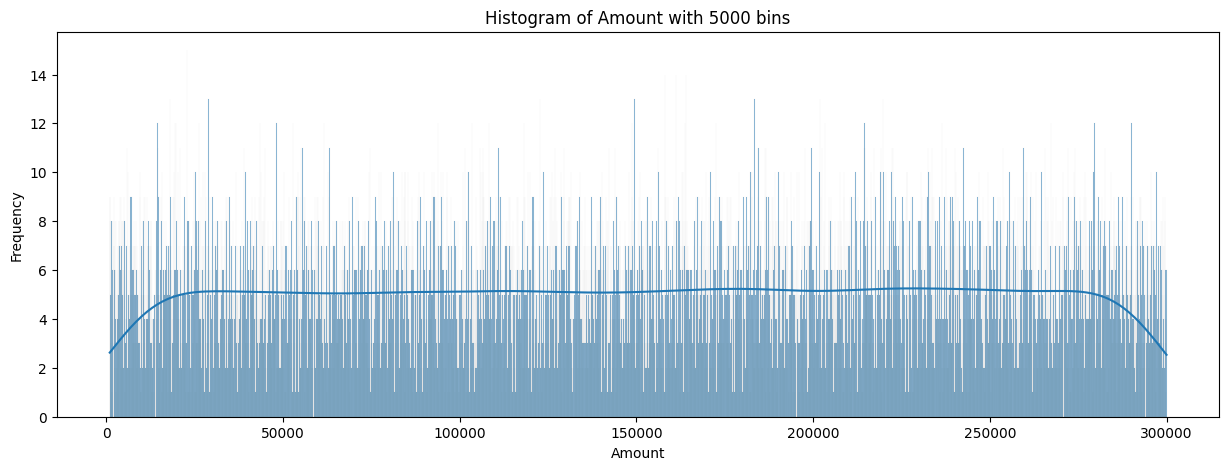

In [116]:
plt.figure(figsize=(15, 5))
sns.histplot(data['Amount'], bins=5000, kde=True)
plt.title('Histogram of Amount with 5000 bins')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [117]:
data['Amount'].describe()

count     25754.000000
mean     150761.123204
std       86378.678898
min        1005.000000
25%       76197.500000
50%      151439.500000
75%      225409.250000
max      299981.000000
Name: Amount, dtype: float64

In [118]:
data.head()

,City,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,Delhi,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,Greater Mumbai,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,Bengaluru,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,Greater Mumbai,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,Bengaluru,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1


In [119]:
data.drop(columns = ['City','Month','Day','MonthName','DayName','Year'],inplace = True)

/tmp/ipykernel_33/761235805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns = ['City','Month','Day','MonthName','DayName','Year'],inplace = True)


In [34]:
data.head()

,Card Type,Exp Type,Gender,Amount,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,Gold,Bills,F,82475,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,Platinum,Bills,F,32555,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,Silver,Bills,F,101738,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,Signature,Bills,F,123424,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,Gold,Bills,F,171574,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1


In [38]:
df = pd.get_dummies(data)

In [39]:
df.head()

,Amount,MonthSin,MonthCos,DaySin,DayCos,Card Type_Gold,Card Type_Platinum,Card Type_Signature,Card Type_Silver,Exp Type_Bills,Exp Type_Entertainment,Exp Type_Food,Exp Type_Fuel,Exp Type_Grocery,Exp Type_Travel,Gender_F,Gender_M,City Tier_Tier-1,City Tier_Tier-2,City Tier_Tier-3
0,82475,-1.000000,-1.836970e-16,0.974928,-0.222521,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False
1,32555,-0.500000,-8.660254e-01,-0.433884,-0.900969,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True
2,101738,-0.500000,-8.660254e-01,0.974928,-0.222521,False,False,False,True,True,False,False,False,False,False,True,False,True,False,False
3,123424,1.000000,6.123234e-17,-0.974928,-0.222521,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True
4,171574,0.866025,-5.000000e-01,0.781831,0.623490,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False


In [40]:
# Devide the data into X and Y
X = df.drop('Amount', axis=1) # Drop the Amount and Make the amount Response
y = np.array(df['Amount'])

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (25754, 19)
y shape:  (25754,)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training, validation, and testing sets
print("X size: ", len(X))
print("y size: ", len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train size: ", len(X_train))
print("y_train size: ", len(y_train))
print("X_test size: ", len(X_test))
print("y_test size: ", len(y_test))
print("test/Total :", len(X_test)/(len(X_train)+ len(X_test)))
# Training is 80% and Test is 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("X_train size: ", len(X_train))
print("y_train size: ", len(y_train))
print("X_val size: ", len(X_val))
print("y_val size: ", len(y_val))
print("Train/Total :", len(X_train)/(len(X)))
print("Val/Total :", len(X_val)/(len(X)))
# Training is 64% and validation is 16%

X size:  25754
y size:  25754
X_train size:  20603
y_train size:  20603
X_test size:  5151
y_test size:  5151
test/Total : 0.2000077657839559
X_train size:  16482
y_train size:  16482
X_val size:  4121
y_val size:  4121
Train/Total : 0.6399782558049235
Val/Total : 0.1600139784111206


In [42]:
scaler = StandardScaler()
scaler.fit(pd.DataFrame(y_train))
y_train = np.concatenate(scaler.transform(pd.DataFrame(y_train)), axis=0)
y_test = np.concatenate(scaler.transform(pd.DataFrame(y_test)), axis=0)
y_val = np.concatenate(scaler.transform(pd.DataFrame(y_val)), axis=0)

In [43]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [45]:
XGB_approx_hp={'max_depth':hp.quniform("max_depth", 4, 30, 1),
        'learning_rate':hp.uniform('learning_rate', 0.01, 0.2, 0.1),
        'n_estimators':hp.quniform('n_estimators', 25, 100, 1),
        'objective':'reg:squarederror',
        'seed':42,
        'verbosity':0
    }

def XGB_par(space):
    model=xgb.XGBRegressor(
                    n_estimators =int(space['n_estimators']),
                    max_depth = int(space['max_depth']),
                    learning_rate=space['learning_rate'],
                    seed=space['seed'],
                    objective=space['objective'], 
                    verbosity=space['verbosity'], 
                    early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)

    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val,y_pred)

    return {'loss': mse, 'status': STATUS_OK }

In [46]:
trials = Trials()
print("XGB optimization:")
XGB_best_hyperparams = fmin(fn = XGB_par,
                        space = XGB_approx_hp,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)



XGB optimization:
100%|██████████| 100/100 [00:18<00:00,  5.29trial/s, best loss: 0.9962816642218811]


In [47]:
XGB_model = xgb.XGBRegressor(objective ='reg:squarederror'
                                 , learning_rate = XGB_best_hyperparams['learning_rate']
                                 , max_depth = int(XGB_best_hyperparams['max_depth'])
                                 , n_estimators = int(XGB_best_hyperparams['n_estimators'])
                                 , seed=42
                                 , verbosity=0)

model = XGB_model

In [48]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08466200800750993,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=94, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
y_pred = model.predict(X_test)

In [130]:
r2_XGB = r2_score(y_test, y_pred)
print("R2 Score", r2_XGB)

R2 Score 0.3277519706057709
